The plotting notebook from "Contemporary Symbolic Regression Methods and their Relative Performance" (https://github.com/cavalab/srbench).

# Ground-Truth problems

These are problems for which the data generating process is a known model, 

$$ y = \phi^*(\mathbf{x}, \theta^*) $$

We assess how well symbolic regression algorithms find the form of the model, $\phi^*$, with some leniency on $\theta^*$ (we allow the model to be off by a constant or a scalar). 

You can just skip to point 3 if there is no aditioal calculation to be done
1. Read finished parfam_data in df_parfam and df_sum
2. Plots:

2.1 Pointplot

2.2 Pairgrid 

# 1. Read df_sum and df_parfam

In [2]:
df_parfam = pd.read_csv("results_parfam.csv")
df_sum = pd.read_csv('symbolic_dataset_results_sum.csv.gz', compression='gzip')

# 2. Plots

In [4]:
#some r2 values in df_sum are negative. just set themto zero
df_sum["r2_test"] = df_sum["r2_test"].apply(lambda x: max(x, 0))
#Add df_parfam to df_sum
df_sum = pd.concat([df_sum, df_parfam], ignore_index=True)

In [5]:
def prepare_dataframe(df):
    ''' Get rid of following formulas: feynman_I_26_2,arcsin(n*sin(theta2)),feynman_I_30_5,arcsin(lambd/(n*d))
                                   feynman_test_10,arccos((cos(theta2)-v/c)/(1-v/c*cos(theta2))), feynman_I_15_10, no formula
    '''
    df = df[~df['dataset'].isin(['feynman_I_26_2', 'feynman_I_30_5','feynman_test_10','feynman_I_15_10'])]
    df=df[df['target_noise'].isin([0,0.01])]
    #df_sum=df_sum[df_sum["data_group"]=="Feynman"]
    df.reset_index(drop=True, inplace=True) # Reset the index
    df= df.drop_duplicates()
    #df_sum
    return df

In [7]:
df_sum = prepare_dataframe(df_sum)

In [8]:
#Compute ranks again
#df_sum['model_size_rank']=df_sum.groupby(['dataset','target_noise'])['model_size'].apply(
        #lambda x:  round(x,3).rank(ascending=True).astype(int) ).reset_index(drop=True)
#df_sum['r2_test_rank']=df_sum.groupby(['dataset','target_noise'])['r2_test'].apply(
        #lambda x:  round(x,3).rank(ascending=False).astype(int) ).reset_index(drop=True)

## 2.1 Pointplot: plot comparisons

In [26]:
def plot_errorbars(x):
    global var
    confidence_level = 0.95
    # print(len(x))
    
    if (var % 30) >1:
        mean = np.mean(x)
        margin_of_error = 1.96 * np.std(x) / np.sqrt(len(x))  # Calculate the margin of error for a 95% confidence interval
        x1 = mean - margin_of_error
        x2 = mean + margin_of_error
    else:   
        x1 = np.nan
        x2 = np.nan
    var +=1
    return (x1,x2)

sns.set_style('whitegrid')
def compare(df_compare=None, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[], est=np.mean,
            orient='h', hue=None,order=None, legend=True, **kwargs):
    
    df_compare = df_compare.copy()
        
    # #Add empty column if we use accuracy solution and the whole datset 
    # if x == 'accuracy_solution' and col ==None:
    #     new_row = {'algorithm': 'DGSR', 'accuracy_solution': 0.9095,'target_noise':0.0,'feature_noise':0.0}
    #     df_compare = pd.concat([df_compare, pd.DataFrame([new_row])], ignore_index=True)
    #     #Ccompute order again since DGSR was added
    #     tmp =  df_compare.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].apply(np.mean).unstack().mean()
    #     order = tmp.sort_values(ascending=False).index.tolist() # Sort values
    #     #Set ParFam to first value of order
    #     order.remove("ParFam")
    #     order.remove("DGSR")
    #     order = ["ParFam","DGSR"]+order
    #     order = pd.Index(order,name='algorithm')

    if row==None and col == None:
        aspect=1
    else:
        aspect=0.65
#     plt.figure(figsize=(8,7))
    if order is None:
        tmp = df_compare.groupby(['target_noise',y])[x].apply(est).unstack().mean()
        order = tmp.sort_values(ascending=False).index
    
    for c in [x,y,row,col]:
        if c:
            df_compare = df_compare.rename(columns={c:c.replace('_',' ').title()})
        
    x = x.replace('_',' ').title()
    y = y.replace('_',' ').title()
    if row:
        row = row.replace('_',' ').title()
    if col:
        col = col.replace('_',' ').title()
    
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    if orient=='v':
        tmp = x
        x = y
        y = tmp
    if col and not row:
        col_wrap = min(4, df_compare[col].nunique()) 
    else:
        col_wrap=None

    cat_args = dict(
                data=df_compare, 
                kind='point',
                y=y,
                x=x,
                order=order,
                row=row,
                col=col,
                col_wrap=col_wrap,
                palette='flare_r',
                margin_titles=True,
                aspect=aspect,
                hue=hue,
                legend_out=False,
                errorbar = None  # plot_errorbars
    )
    cat_args.update(kwargs)
    g = sns.catplot( **cat_args )
    
    #Add Legend
    if hue:
        g._legend.remove() #(title=hue.replace('_',' ').title())
        g.axes.flat[-1].legend(title=hue.replace('_',' ').title(),fontsize=10,loc='lower right')
    
    if not legend:
        g._legend.remove()
    
    for ax in g.axes.flat: 
        ax.yaxis.grid(True)
        ax.set_ylabel('')
        #Set ParFam index to bold on y axis
        y_labels = ax.get_yticklabels()
        if y_labels:
            parfam_order = order.index('ParFam')
            dlparfam_order = order.index('DL-ParFam')
            y_labels[parfam_order].set_fontweight('bold')
            y_labels[dlparfam_order].set_fontweight('bold')
            ax.set_yticklabels(y_labels)
            
        ax.set_xlabel(ax.get_xlabel().replace('Symbolic ',''))
        if col:
            ttl = ax.get_title()
            ax.set_title(ttl.replace(col,'').replace('=',''))
    #Set title for no data_group
    if col is None:
        plt.title("SRBench ground-truth problems")
    
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)

    sns.despine(left=True, bottom=True)
    x = x.replace('(%)', 'pct')
    savename = '-'.join(['cat-'+cat_args['kind']+'plot',x+ '-by-'+ y])
    if row: savename += '_'+row
    if col: savename += '_'+col
    #Remove legend if necessary
    #savename+="_without_legend"
    #g._legend.remove()
    
    save(g, savename )

In [27]:
order

['PySR',
 'ParFam',
 'AIFeynman',
 'DL-ParFam',
 'uDSR',
 'AFP_FE',
 'DSR',
 'AFP',
 'GP-GOMEA',
 'gplearn',
 'ITEA',
 'EPLEX',
 'Operon',
 'SBP-GP',
 'BSR',
 'EndToEnd',
 'FEAT',
 'MRGP',
 'FFX']

In [28]:
df_sum.groupby(['algorithm', 'target_noise'])['accuracy_solution'].mean()

algorithm  target_noise
AFP        0.00            0.422481
           0.01            0.399225
AFP_FE     0.00            0.554264
           0.01            0.500000
AIFeynman  0.00            0.736220
           0.01            0.676000
BSR        0.00            0.120155
           0.01            0.120155
DL-ParFam  0.00            0.829457
           0.01            0.837209
DSR        0.00            0.240310
           0.01            0.251938
EPLEX      0.00            0.437984
           0.01            0.519380
EndToEnd   0.00            0.457364
           0.01            0.364486
FEAT       0.00            0.395349
           0.01            0.403101
FFX        0.00            0.000000
           0.01            0.027132
GP-GOMEA   0.00            0.713178
           0.01            0.732558
ITEA       0.00            0.271318
           0.01            0.271318
MRGP       0.00            0.926357
           0.01            0.883721
Operon     0.00            0.868217
    

/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Symbolic-Solution-Rate-pct-by-Algorithm.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Symbolic-Solution-Rate-pct-by-Algorithm_Data-Group.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Accuracy-Solution-by-Algorithm.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Accuracy-Solution-by-Algorithm_Data-Group.pdf


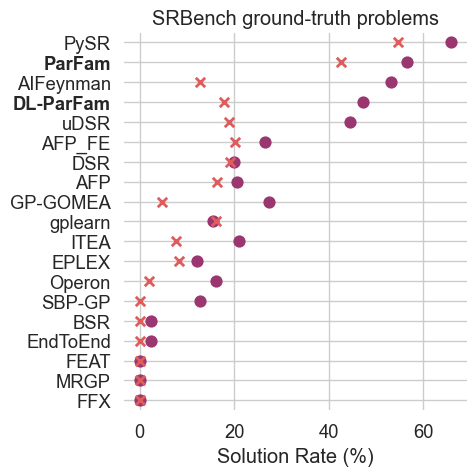

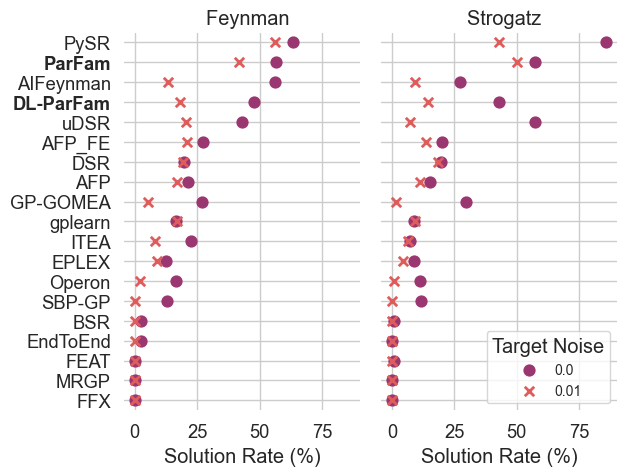

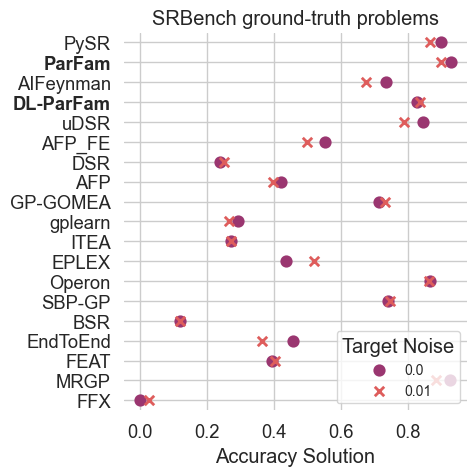

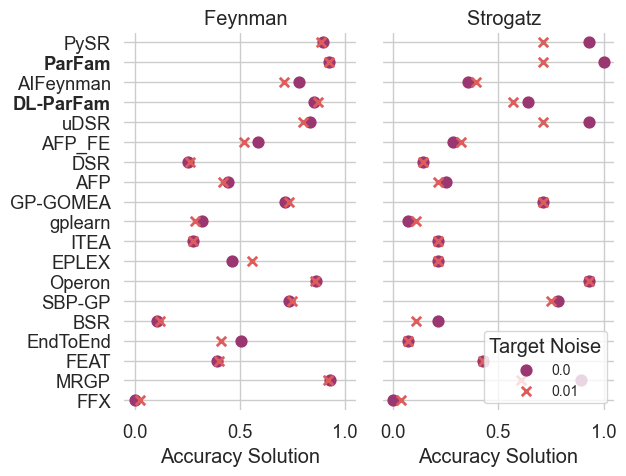

In [29]:
#Calculate on order used for all pirctures
tmp =  df_sum.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].apply(np.mean).unstack().mean()
order = tmp.sort_values(ascending=False).index.tolist() # Sort values
#Set ParFam to first value of order
# order.remove("ParFam")
# order.remove('DL-ParFam')
# order = ["DL-ParFam"]+order
# order = ["ParFam"]+order
# order = pd.Index(order,name='algorithm')
#


#'accuracy_solution','r2_test',
for metric in ['symbolic_solution_rate_(%)','accuracy_solution']:
# for metric in ['r2_test']:
    for kind in ['point']: #,'strip']:
        args =dict(df_compare=df_sum, x=metric, est=np.mean, orient='h',
                   kind=kind,order=order) 
        if kind=='point': 
            args['join'] = False 
            args['markers']=['o','x','s','+']
        if metric == 'r2_test':
            args['xlim'] = [0.5, 1]
        var=0
        if metric == 'symbolic_solution_rate_(%)':
            legend = False
        else:
            legend = True   
        compare(**args,
                hue='target_noise', 
                col=None,
                legend=legend
                ) 
        compare(**args, 
                hue='target_noise', 
                col='data_group',
                legend=True
                ) 

In [30]:
# For comparison vs DGSR
(df_sum[(df_sum['algorithm']=='ParFam') & (df_sum['target_noise'] == 0.0)]['r_squared_test'] > 0.99).mean() 

0.9767441860465116

## 2.2 PairGrid

In [31]:
def plot_errorbars_mean(x):
    global var
    confidence_level = 0.95
    # print(len(x))
    
    if (var % 30) >1:
        mean = np.mean(x)
        margin_of_error = 1.96 * np.std(x) / np.sqrt(len(x))  # Calculate the margin of error for a 95% confidence interval
        x1 = mean - margin_of_error
        x2 = mean + margin_of_error
    else:   
        x1 = np.nan
        x2 = np.nan
    var +=1
    return (x1,x2)


#In order to not plot standard deviation for ParFam
def plot_errorbars_median(x):
    global var

    confidence_level = 0.95
    num_bootstrap_samples = 1000
    # print(var)
    # print(f'Length of x: {len(x)}')
    if (var%30==25) | (var%30==26):
        median_ci = (np.nan, np.nan)
    else:
        median_ci = np.percentile(np.median(np.random.choice(x, (num_bootstrap_samples, len(x)), replace=True), axis=1), 
                                  [(1 - confidence_level) / 2 * 100, (1 + confidence_level) / 2 * 100])

        
    var += 1
    return median_ci

def pairgrid(df_plot,x_vars,order,datagroup="", estimator_str='mean'):
    if datagroup!="":
        df_plot = df_plot[df_plot["data_group"]==datagroup]

    g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=6.5, 
                 aspect=0.7,
                 hue='target_noise',
                 palette='flare_r'
#                  hue_order=[0.01,0.001,0]
#                  hue='dataset'
                )
    
    if estimator_str == 'mean':
        estimator = np.mean
    else:
        estimator = np.median
        
    g.map(sns.pointplot, 
          #size=10,
          orient="h",
          #jitter=False,
          order=order,
          palette='flare_r',
          errwidth=2,
          #linewidth=0.01,
          #markeredgecolor='w',
          join=False,
          estimator=estimator,
          n_boot=1000,
          markers=['o','x'],
          scale=1.2,
          errorbar = None # plot_errorbars_median
          #markeralpha=0.5
         )
    if datagroup=="":
        g.fig.suptitle("SRBench ground-truth problems",y=1.02)
    else:
        g.fig.suptitle(datagroup,y=1.02)
    #Set ParFam index to bold on y axis
    subplot_index=0
    y_labels = g.axes[subplot_index, 0].get_yticklabels()
    parfam_order = order.index('ParFam')
    dlparfam_order = order.index('DL-ParFam')
    y_labels[parfam_order].set_fontweight('bold')
    y_labels[dlparfam_order].set_fontweight('bold')
    g.axes[subplot_index, 0].set_yticklabels(y_labels)

    plt.legend(title='Target Noise')
    titles = [x.replace('_',' ').title().replace('(S)','(s)') for x in x_vars]

    for ax, title in zip(g.axes.flat, titles):

        # remove xlabel
        ax.set_xlabel('')
        ax.set_ylabel('')
        # Set a different title for each axes
        ax.set(title=title)
        if any([n in title.lower() for n in ['size','complexity','time']]):
            ax.set_xscale('log')
        if 'R2' in title and 'Rank' not in title:            
            ax.set(title=title.replace('R2','$R^2$'))
            ax.set_xscale('logit')
            
            if estimator_str == 'mean':
                ax.set_xlim([0.5,0.9999])
                labels = ['0.5', '0.9', '0.99', '0.999', '0.9999']
                ax.set_xticklabels(labels)#, rotation=90)
            else:
                ax.set_xlim([0.5,0.999999999999999])
                labels = ['0.5',r'$1-10^{-3}$',r'$1-10^{-6}$',r'$1-10^{-9}$',r'$1-10^{-12}$',r'$1-10^{-15}$']
                ax.set_xticklabels(labels, rotation=45)
            
        # Make the grid horizontal instead of vertical
        ax.yaxis.grid(True)
        
    x_vars = '_'.join(x_vars)
    x_vars = x_vars.replace('(s)', 's')
    save(g, 'pairgrid_'+x_vars+'_'+datagroup+estimator_str)

/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may ch

saving pairgrid_r2_test_model_size_training-time-s_mean.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may ch

saving pairgrid_r2_test_model_size_training-time-s_median.pdf


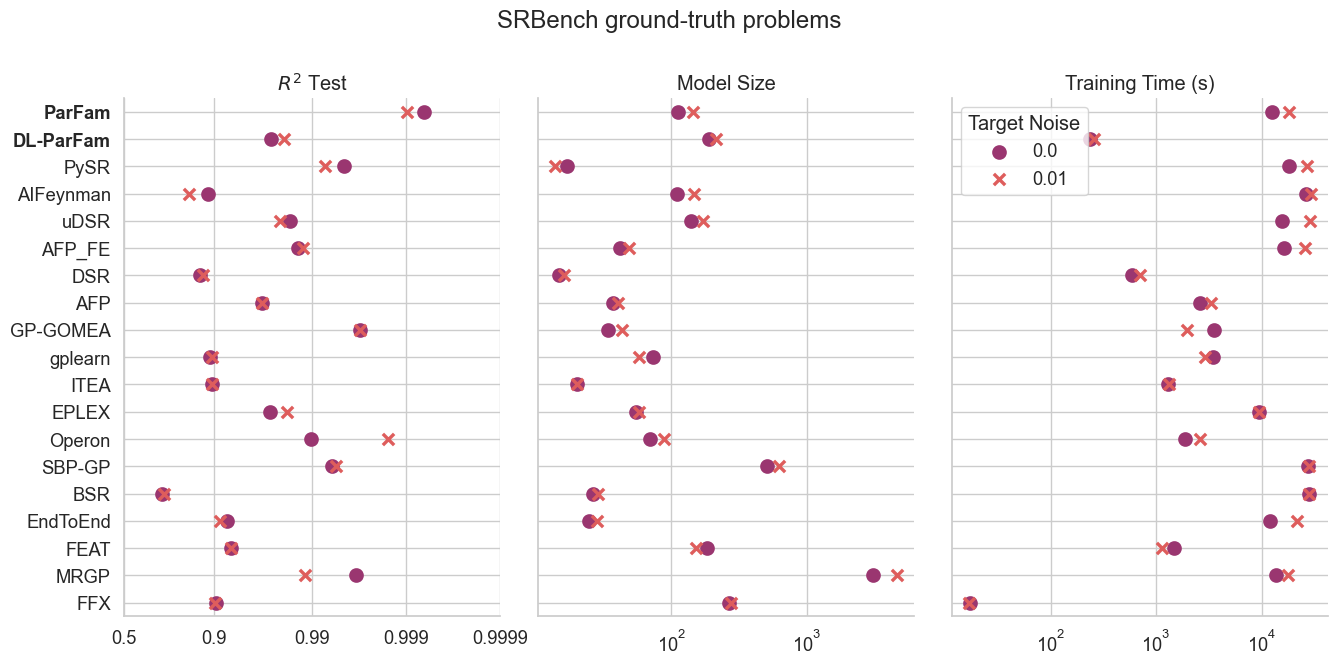

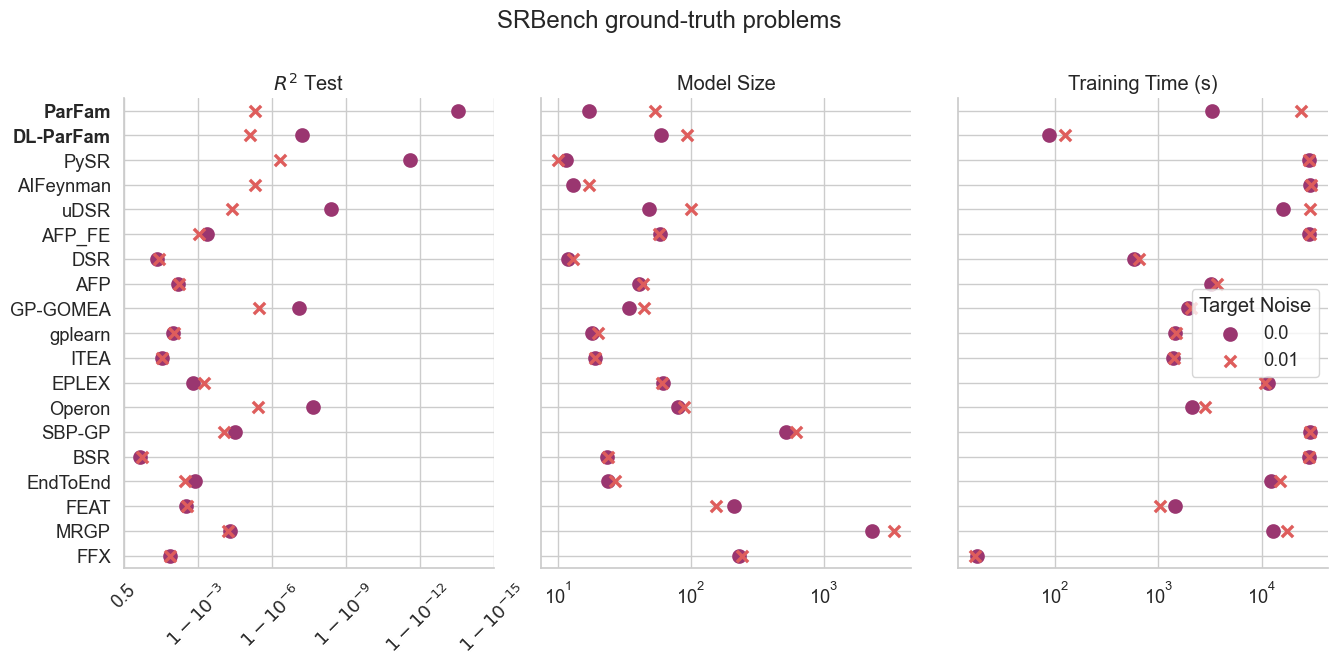

In [32]:
var = 0
# Make the PairGrid
df_plot = df_sum.copy()
tmp = df_plot.groupby(['target_noise','algorithm'])['symbolic_solution_rate'].mean().unstack().mean()
order = tmp.sort_values(ascending=False).index.tolist()
#Set ParFam to first value of order
order.remove("ParFam")
order.remove('DL-ParFam')
order = ["DL-ParFam"]+order
order = ["ParFam"]+order
order = pd.Index(order,name='algorithm')

df_plot['size_diff'] = df_plot['model_size']-df_plot['simplified_complexity']+1
x_vars=[
        # 'symbolic_solution_rate_(%)',
        # 'accuracy_solution_rate_(%)',
        # 'mse_test',
        # 'r2_test_rank',
#         'r2_test_norm',
        'r2_test',
        #'simplified_complexity',
#         'size_diff',
        'model_size',
        'training time (s)',
#         'solution'
]

for datagroup in [""]: #,"Feynman","Strogatz"]:
    pairgrid(df_plot,x_vars,order,datagroup, estimator_str='mean')
    pairgrid(df_plot,x_vars,order, datagroup, estimator_str='median')


In [263]:
# Why is AIFeynman not visible in the median plot of R²?
df_sum[(df_sum['algorithm'] == 'AIFeynman') & (df_sum['target_noise'] == 0)][['r2_test', 'mse_test']].min()

r2_test     0.000000e+00
mse_test    6.159482e-33
dtype: float64